<center><img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Understanding%20Clouds%20from%20Satellite%20Images/banner.png" width="800"></center>
<h1><center>Understanding Clouds from Satellite Images</center></h1><p></p>
<h2><center>Cloud Segmentation with utility scripts and Keras</center></h2>

#### This kernel is to show the new feature on Kaggle, script notebooks. I'm not doing EDA here because I already did it on [my other kernel](https://www.kaggle.com/dimitreoliveira/understanding-clouds-eda-and-keras-u-net), the goal here is just to demonstrate how to use script notebook and how it can improve our work, making it faster and cleaner.
#### I found this addition really cool as I always try to write clean and modular code, it always saves time later, this may be another push towards better software practices on data science projects.

What you will find on the [script I made](https://www.kaggle.com/dimitreoliveira/cloud-images-segmentation-utillity-script):
- All used dependencies
- External repository codes (need internet option ON)
- Seed function (to make model runs more reproducible)
- Segmentation functions related to this competition
- Multi-thread data process functions (to resize and apply transformations faster)
- Model evaluation (training plots)
- Model post-process (Set threshold and removing small masks)
- Prediction evaluation (Generate metrics over predictions and sample evaluation)
- Data generator
- Learning rate schedulers

##### If you have any request to update or add anything to the scripts please let me know in the comments.

### Dependencies

In [1]:
# Link for the script https://www.kaggle.com/dimitreoliveira/cloud-images-segmentation-utillity-script
from cloud_images_segmentation_utillity_script import *

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


### Load data

In [2]:
train = pd.read_csv('../input/understanding_cloud_organization/train.csv')
submission = pd.read_csv('../input/understanding_cloud_organization/sample_submission.csv')

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])

# Create one column for each mask
train_df = pd.pivot_table(train, index=['image'], values=['EncodedPixels'], columns=['label'], aggfunc=np.min).reset_index()
train_df.columns = ['image', 'Fish_mask', 'Flower_mask', 'Gravel_mask', 'Sugar_mask']

print('Compete set samples:', len(train_df))
print('Test samples:', len(submission))

display(train.head())

Compete set samples: 5546
Test samples: 14792


,Image_Label,EncodedPixels,image,label
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish


## Train and validation split

In [3]:
X_train, X_val = train_test_split(train_df, test_size=0.2, random_state=seed)
X_train['set'] = 'train'
X_val['set'] = 'validation'
test['set'] = 'test'

print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))

Train samples:  4436
Validation samples:  1110


# Model parameters

In [4]:
BACKBONE = 'resnet50'
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 3e-4
HEIGHT = 256
WIDTH = 384
CHANNELS = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
model_path = '../working/uNet_%s_%sx%s' % (BACKBONE, HEIGHT, WIDTH)

In [5]:
preprocessing = sm.backbones.get_preprocessing(BACKBONE)

augmentation = albu.Compose([albu.HorizontalFlip(p=0.5),
                             albu.VerticalFlip(p=0.5),
                             albu.GridDistortion(p=0.5)
                            ])

# Pre-process data

In [6]:
train_base_path = '../input/understanding_cloud_organization/train_images/'
test_base_path = '../input/understanding_cloud_organization/test_images/'
train_images_dest_path = 'base_dir/train_images/'
validation_images_dest_path = 'base_dir/validation_images/'
test_images_dest_path = 'base_dir/test_images/'

# Making sure directories don't exist
if os.path.exists(train_images_dest_path):
    shutil.rmtree(train_images_dest_path)
if os.path.exists(validation_images_dest_path):
    shutil.rmtree(validation_images_dest_path)
if os.path.exists(test_images_dest_path):
    shutil.rmtree(test_images_dest_path)
    
# Creating train, validation and test directories
os.makedirs(train_images_dest_path)
os.makedirs(validation_images_dest_path)
os.makedirs(test_images_dest_path)

def preprocess_data(df, HEIGHT=HEIGHT, WIDTH=WIDTH):
    '''
    This function needs to be defined here, because it will be called with no arguments, 
    and must have the default parameters from the beggining of the notebook (HEIGHT and WIDTH)
    '''
    df = df.reset_index()
    for i in range(df.shape[0]):
        item = df.iloc[i]
        image_id = item['image']
        item_set = item['set']
        if item_set == 'train':
            preprocess_image(image_id, train_base_path, train_images_dest_path, HEIGHT, WIDTH)
        if item_set == 'validation':
            preprocess_image(image_id, train_base_path, validation_images_dest_path, HEIGHT, WIDTH)
        if item_set == 'test':
            preprocess_image(image_id, test_base_path, test_images_dest_path, HEIGHT, WIDTH)

# Pre-procecss train set
pre_process_set(X_train, preprocess_data)

# Pre-procecss validation set
pre_process_set(X_val, preprocess_data)

# Pre-procecss test set
pre_process_set(test, preprocess_data)

# Data generator

In [7]:
train_generator = DataGenerator(
                  directory=train_images_dest_path,
                  dataframe=X_train,
                  target_df=train,
                  batch_size=BATCH_SIZE,
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  augmentation=augmentation,
                  seed=seed)

valid_generator = DataGenerator(
                  directory=validation_images_dest_path,
                  dataframe=X_val,
                  target_df=train,
                  batch_size=BATCH_SIZE, 
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  seed=seed)

# Model

In [8]:
model = sm.Unet(backbone_name=BACKBONE, 
                encoder_weights='imagenet',
                classes=N_CLASSES,
                activation='sigmoid',
                input_shape=(HEIGHT, WIDTH, CHANNELS))

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

metric_list = [dice_coef, sm.metrics.iou_score]
callback_list = [checkpoint, es, rlrop]
optimizer = RAdam(learning_rate=LEARNING_RATE, warmup_proportion=0.1)

model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)
model.summary()

94593024/94592056 [==============================] - 4s 0us/step
Model: "u-resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 384, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 384, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 390, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 192, 64) 9408        zero_padding2d_1[0][0]           
________________________

In [9]:
STEP_SIZE_TRAIN = len(X_train)//BATCH_SIZE
STEP_SIZE_VALID = len(X_val)//BATCH_SIZE

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=2).history

Epoch 1/15
 - 289s - loss: 1.3840 - dice_coef: 0.2952 - iou_score: 0.1348 - val_loss: 1.2802 - val_dice_coef: 0.3504 - val_iou_score: 0.1592
Epoch 2/15
 - 287s - loss: 1.1212 - dice_coef: 0.3912 - iou_score: 0.1616 - val_loss: 1.2366 - val_dice_coef: 0.4372 - val_iou_score: 0.1899
Epoch 3/15
 - 267s - loss: 1.0587 - dice_coef: 0.4451 - iou_score: 0.1768 - val_loss: 1.2026 - val_dice_coef: 0.4348 - val_iou_score: 0.1845
Epoch 4/15
 - 270s - loss: 1.0452 - dice_coef: 0.4638 - iou_score: 0.1831 - val_loss: 1.0599 - val_dice_coef: 0.4593 - val_iou_score: 0.1857
Epoch 5/15
 - 266s - loss: 1.0343 - dice_coef: 0.4781 - iou_score: 0.1885 - val_loss: 1.0583 - val_dice_coef: 0.4868 - val_iou_score: 0.1969
Epoch 6/15
 - 269s - loss: 1.0341 - dice_coef: 0.4788 - iou_score: 0.1896 - val_loss: 1.0419 - val_dice_coef: 0.4684 - val_iou_score: 0.1877
Epoch 7/15
 - 268s - loss: 1.0262 - dice_coef: 0.4874 - iou_score: 0.1928 - val_loss: 1.1019 - val_dice_coef: 0.4754 - val_iou_score: 0.1979
Epoch 8/15
 -

## Model loss graph

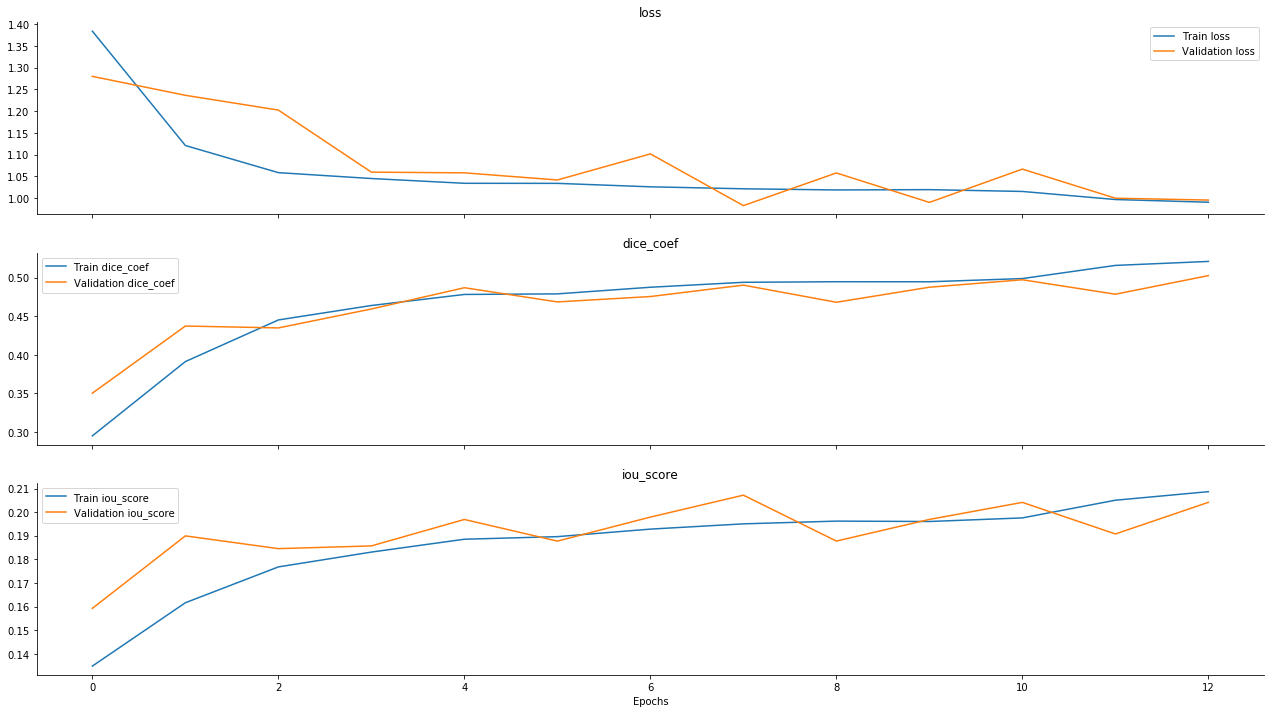

In [10]:
plot_metrics(history, metric_list=['loss', 'dice_coef', 'iou_score'])

# Threshold and mask size tunning
 - Here we could use some kind of parameter search, but to simplify I'm using default values

In [11]:
class_names = ['Fish  ', 'Flower', 'Gravel', 'Sugar ']
best_tresholds = [.55, .55, .55, .55]
best_masks = [10000, 10000, 10000, 10000]

for index, name in enumerate(class_names):
    print('%s treshold=%.2f mask size=%d' % (name, best_tresholds[index], best_masks[index]))

Fish   treshold=0.55 mask size=10000
Flower treshold=0.55 mask size=10000
Gravel treshold=0.55 mask size=10000
Sugar  treshold=0.55 mask size=10000


# Model evaluation

In [12]:
train_metrics = get_metrics(model, train, X_train, train_images_dest_path, best_tresholds, best_masks, seed=seed, preprocessing=preprocessing, set_name='Train')
display(train_metrics)

validation_metrics = get_metrics(model, train, X_val, validation_images_dest_path, best_tresholds, best_masks, seed=seed, preprocessing=preprocessing, set_name='Validation')
display(validation_metrics)

,Dice,Dice Post
Class,,
Fish,0.212799,0.550314
Flower,0.196170,0.767057
Gravel,0.217667,0.566173
Sugar,0.248318,0.588620
Train,0.218738,0.618041


,Dice,Dice Post
Class,,
Fish,0.221952,0.504122
Flower,0.194232,0.723290
Gravel,0.223461,0.510113
Sugar,0.251609,0.557160
Validation,0.222813,0.573671


# Apply model to test set

In [13]:
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_dest_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(HEIGHT, WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = model.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32') 
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds[class_index], min_size=best_masks[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post'] = pred_rles_post
        ###
        
        test_df.append(image_df)

sub_df = pd.concat(test_df)

# Inspecting some of the validation set predictions

## Without post-processing

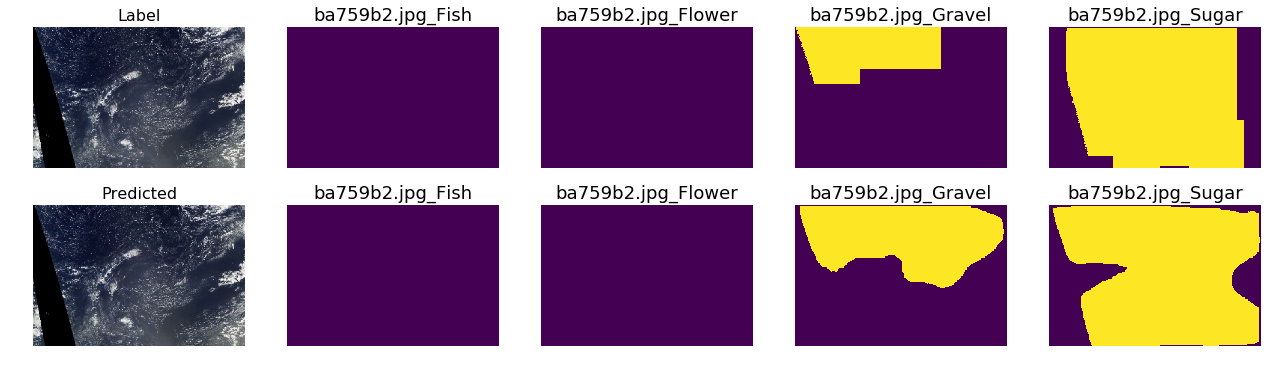

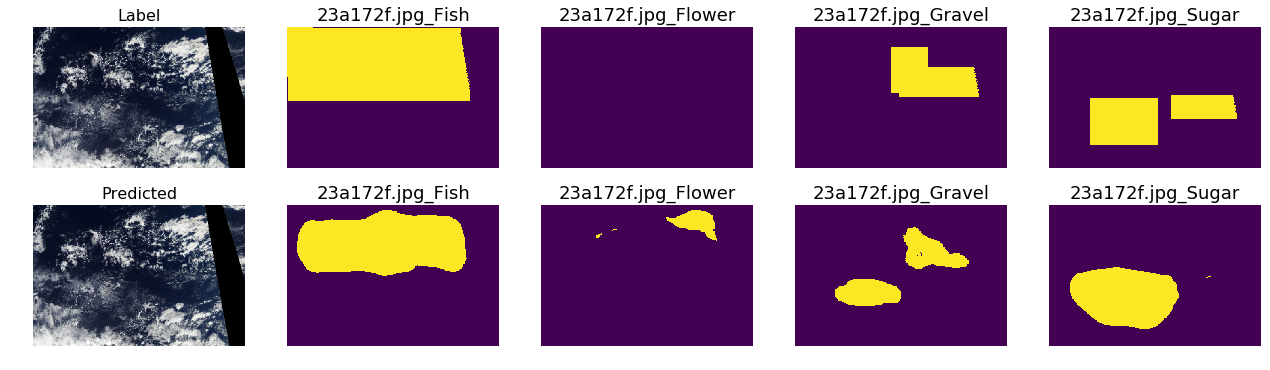

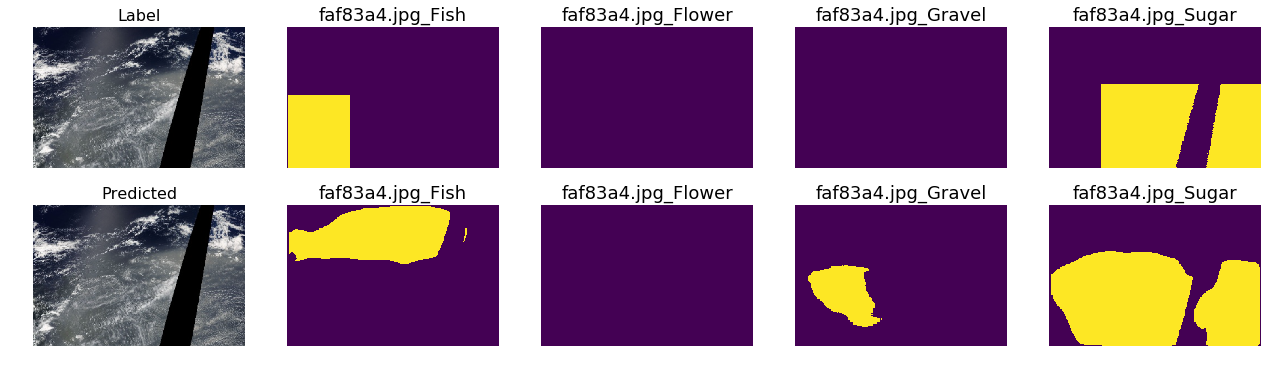

In [14]:
# Choose 3 samples at random
images_to_inspect = np.random.choice(X_val['image'].unique(), 3, replace=False)
inspect_set = train[train['image'].isin(images_to_inspect)].copy()
inspect_set_temp = []

inspect_generator = DataGenerator(
                    directory=validation_images_dest_path,
                    dataframe=inspect_set,
                    target_df=train,
                    batch_size=len(inspect_set), 
                    target_size=(HEIGHT, WIDTH),
                    n_channels=CHANNELS,
                    n_classes=N_CLASSES,
                    preprocessing=preprocessing,
                    seed=seed,
                    mode='fit',
                    shuffle=False)

preds = model.predict_generator(inspect_generator)

for index, b in enumerate(range(len(preds))):
    filename = inspect_set['image'].iloc[b]
    image_df = inspect_set[inspect_set['image'] == filename].copy()
    pred_masks = preds[index, ].round().astype(int)
    pred_rles = build_rles(pred_masks, reshape=(350, 525))
    image_df['EncodedPixels_pred'] = pred_rles
    inspect_set_temp.append(image_df)
    
    ### Post procecssing
    pred_masks_post = preds[index, ].astype('float32') 
    for class_index in range(N_CLASSES):
        pred_mask = pred_masks_post[...,class_index]
        pred_mask = post_process(pred_mask, threshold=best_tresholds[class_index], min_size=best_masks[class_index])
        pred_masks_post[...,class_index] = pred_mask

    pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
    image_df['EncodedPixels_pred_post'] = pred_rles_post
    ###


inspect_set = pd.concat(inspect_set_temp)
inspect_predictions(inspect_set, images_to_inspect, validation_images_dest_path, pred_col='EncodedPixels_pred')

## With post-processing

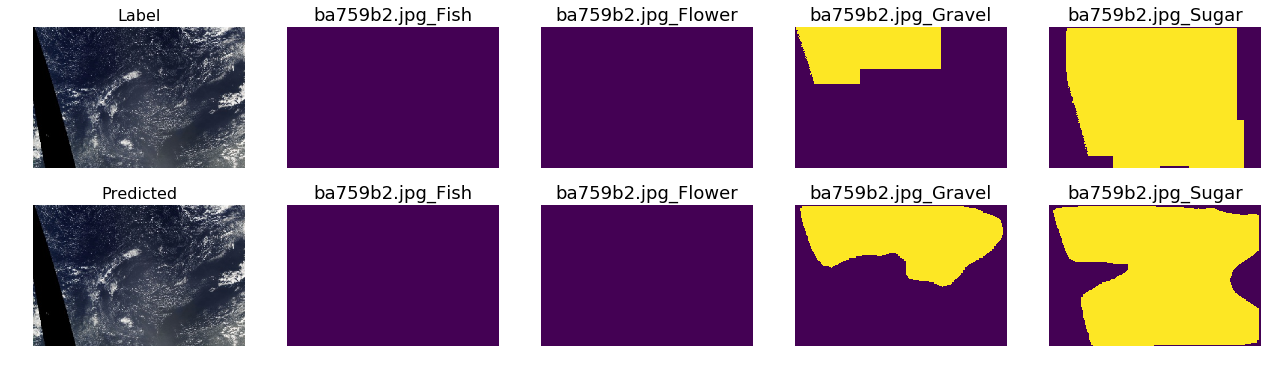

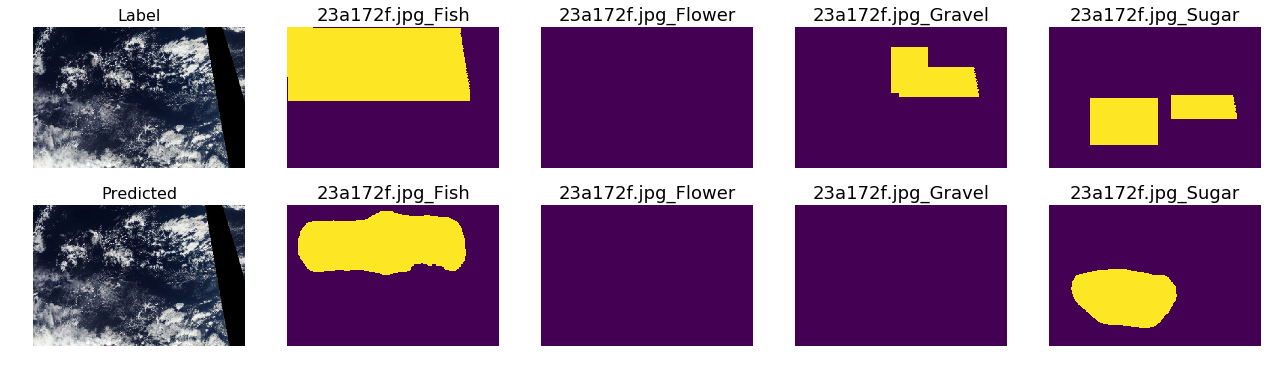

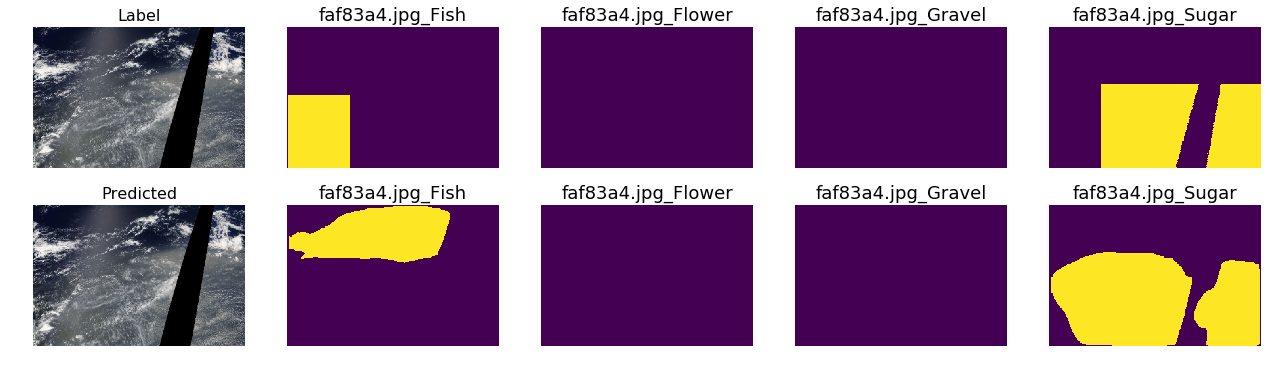

In [15]:
inspect_predictions(inspect_set, images_to_inspect, validation_images_dest_path, pred_col='EncodedPixels_pred_post')

# Inspecting some of the test set predictions

## Without post-process

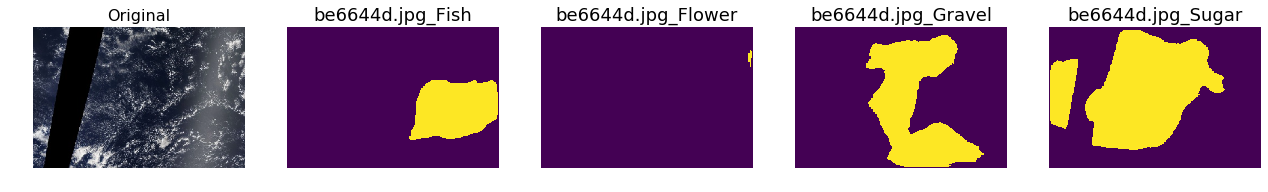

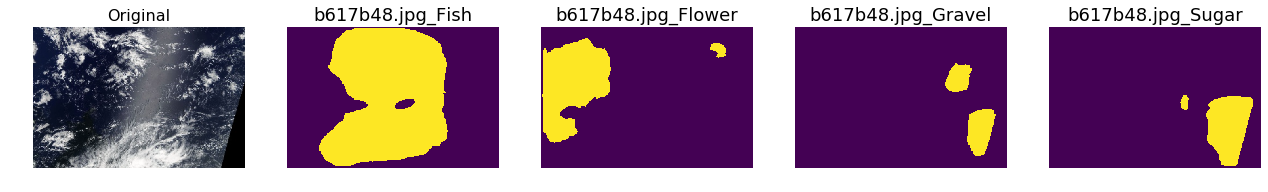

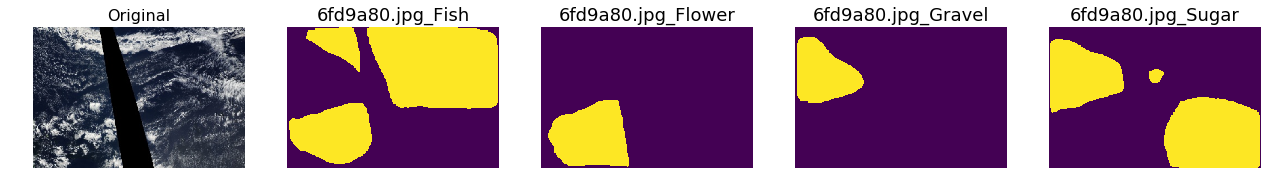

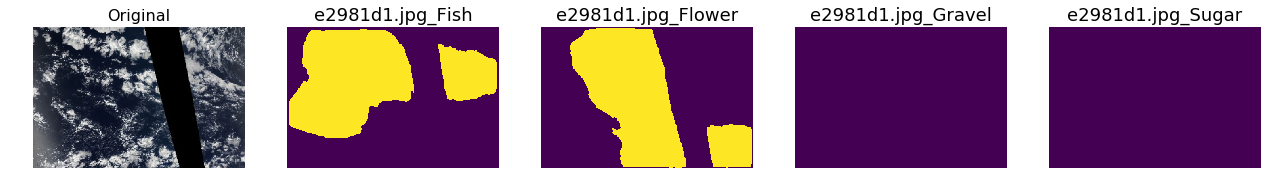

In [16]:
# Choose 5 samples at random
images_to_inspect_test =  np.random.choice(sub_df['image'].unique(), 4)
inspect_predictions(sub_df, images_to_inspect_test, test_images_dest_path)

## With post-process

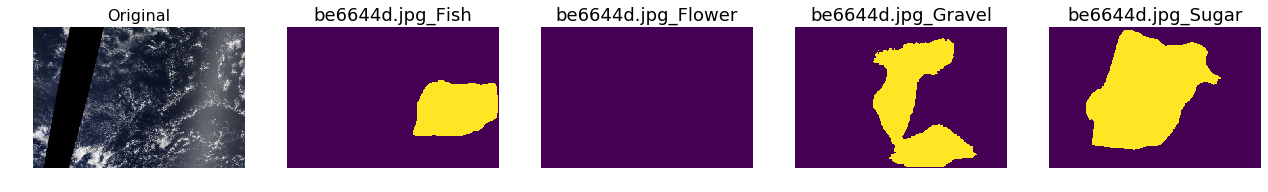

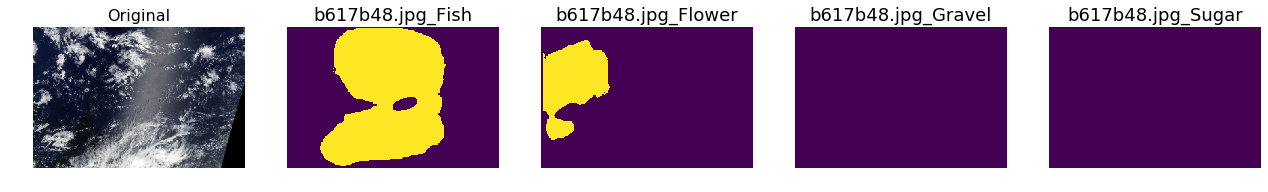

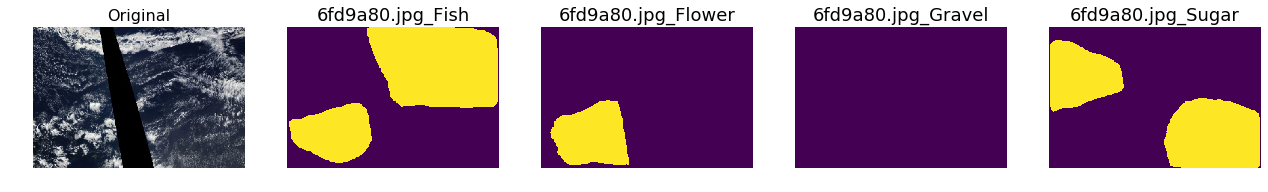

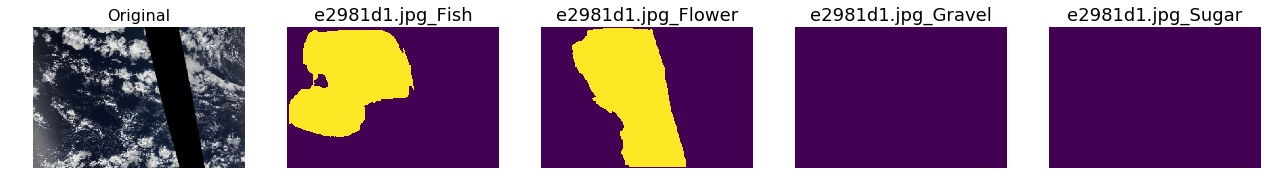

In [17]:
inspect_predictions(sub_df, images_to_inspect_test, test_images_dest_path, label_col='EncodedPixels_post')

### Regular submission

In [18]:
submission_df = sub_df[['Image_Label' ,'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,743 254 1061 317 1411 317 1756 335 2104 344 24...
3,002f507.jpg_Sugar,771 44 1093 94 1443 94 1838 11 2188 11 2538 11...
4,0035ae9.jpg_Fish,85518 4 85868 8 86218 8 86567 13 86917 15 8726...


### Submission with post processing

In [19]:
submission_df_post = sub_df[['Image_Label' ,'EncodedPixels_post']]
submission_df_post.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post.to_csv('submission_post.csv', index=False)
display(submission_df_post.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,767 171 941 12 957 25 1064 309 1414 309 1757 3...
3,002f507.jpg_Sugar,98851 5 98862 4 99201 5 99212 4 99549 9 99562 ...
4,0035ae9.jpg_Fish,91834 4 92182 8 92532 8 92882 6 93229 8 93579 ...


In [20]:
# Cleaning created directories
if os.path.exists(train_images_dest_path):
    shutil.rmtree(train_images_dest_path)
if os.path.exists(validation_images_dest_path):
    shutil.rmtree(validation_images_dest_path)
if os.path.exists(test_images_dest_path):
    shutil.rmtree(test_images_dest_path)